## Project 1: **Finding Lane Lines on the Road** 

## Import packages

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Create helper functions
- Image processing functions: provided by the [Udacity project](https://github.com/udacity/CarND-LaneLines-P1/blob/master/P1.ipynb)

In [47]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    Define a line to run the full length of the visible lane 
    based on the line segments identified.
    
    Separate line segments by their slope ((y2-y1)/(x2-x1)) to decide which 
    segments are part of the left line vs. the right line.  
    Then, you can average the position of each of the lines and extrapolate 
    to the top and bottom of the lane.
    """
    left_lane = np.empty((0, 4))
    right_lane = np.empty((0, 4))
    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2 - y1)/(x2 - x1)
            if (np.abs(k)<0.4) | (np.abs(k)>2):
                continue
            else:
                if k < 0:
                    left_lane = np.vstack((left_lane, np.array([x1, x2, y1, y2])))
                else:
                    right_lane = np.vstack((right_lane, np.array([x1, x2, y1, y2])))
    
    def get_points(points):
        aver_point = np.mean(points, axis=0)
        lane_fit = np.polyfit(aver_point[-2:], aver_point[:2], 1) # x = ky+b
        end_y = 540
        start_y = 330
        end_x = np.int(lane_fit[0]*end_y + lane_fit[1])
        start_x = np.int(lane_fit[0]*start_y + lane_fit[1]) 
        return start_x, start_y, end_x, end_y

    try:
        cv2.line(img, get_points(left_lane)[:2], get_points(left_lane)[-2:], color, thickness)
        cv2.line(img, get_points(right_lane)[:2], get_points(right_lane)[-2:], color, thickness)
    except ValueError:
        pass
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    `rho`: distance rsolution in radians of Hough grid
    `theta`: angular resolution in radians of Hough grid
    `threshold`: minimum number of intersections in Hough grid cell
    `min_line_len`: minimum number of pixels making up a line
    `max_line_gap`: maximum gap in pixels between connectable line segments
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

- Save and display results functions

In [13]:
def showImages(dir):
    """
     Shows the list of images with `imageNames' on the directory `dir`
    """
    imageNames = os.listdir(dir)
    plt.figure(figsize=(50, 20))
    rows = math.ceil(len(imageNames) / 3)
    
    for i, imageName in enumerate(imageNames):
        plt.subplot(rows, 3, i + 1)
        image = mpimg.imread(dir + imageName)
        plt.imshow(image)
    plt.show()
    return imageNames
    
    
def SaveImages(images, targetDir, imgNames, func, isGray=0):
    """
    Save the result obtained after applying the 'func' to the 'images'.
    """
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    
    imageRes = list(map(func, images))
    imagePairs = list(map(lambda x: (targetDir + '/'+ x[0], x[1]), zip(imgNames, imageRes)))
    
    for imagePair in imagePairs:
        if isGray:
            plt.imsave(imagePair[0], imagePair[1], cmap='gray')
        else:
            plt.imsave(imagePair[0], imagePair[1])
    
    showImages(targetDir)
    return imageRes
    

## Build a Lane Finding Pipeline

## 1. Load test images

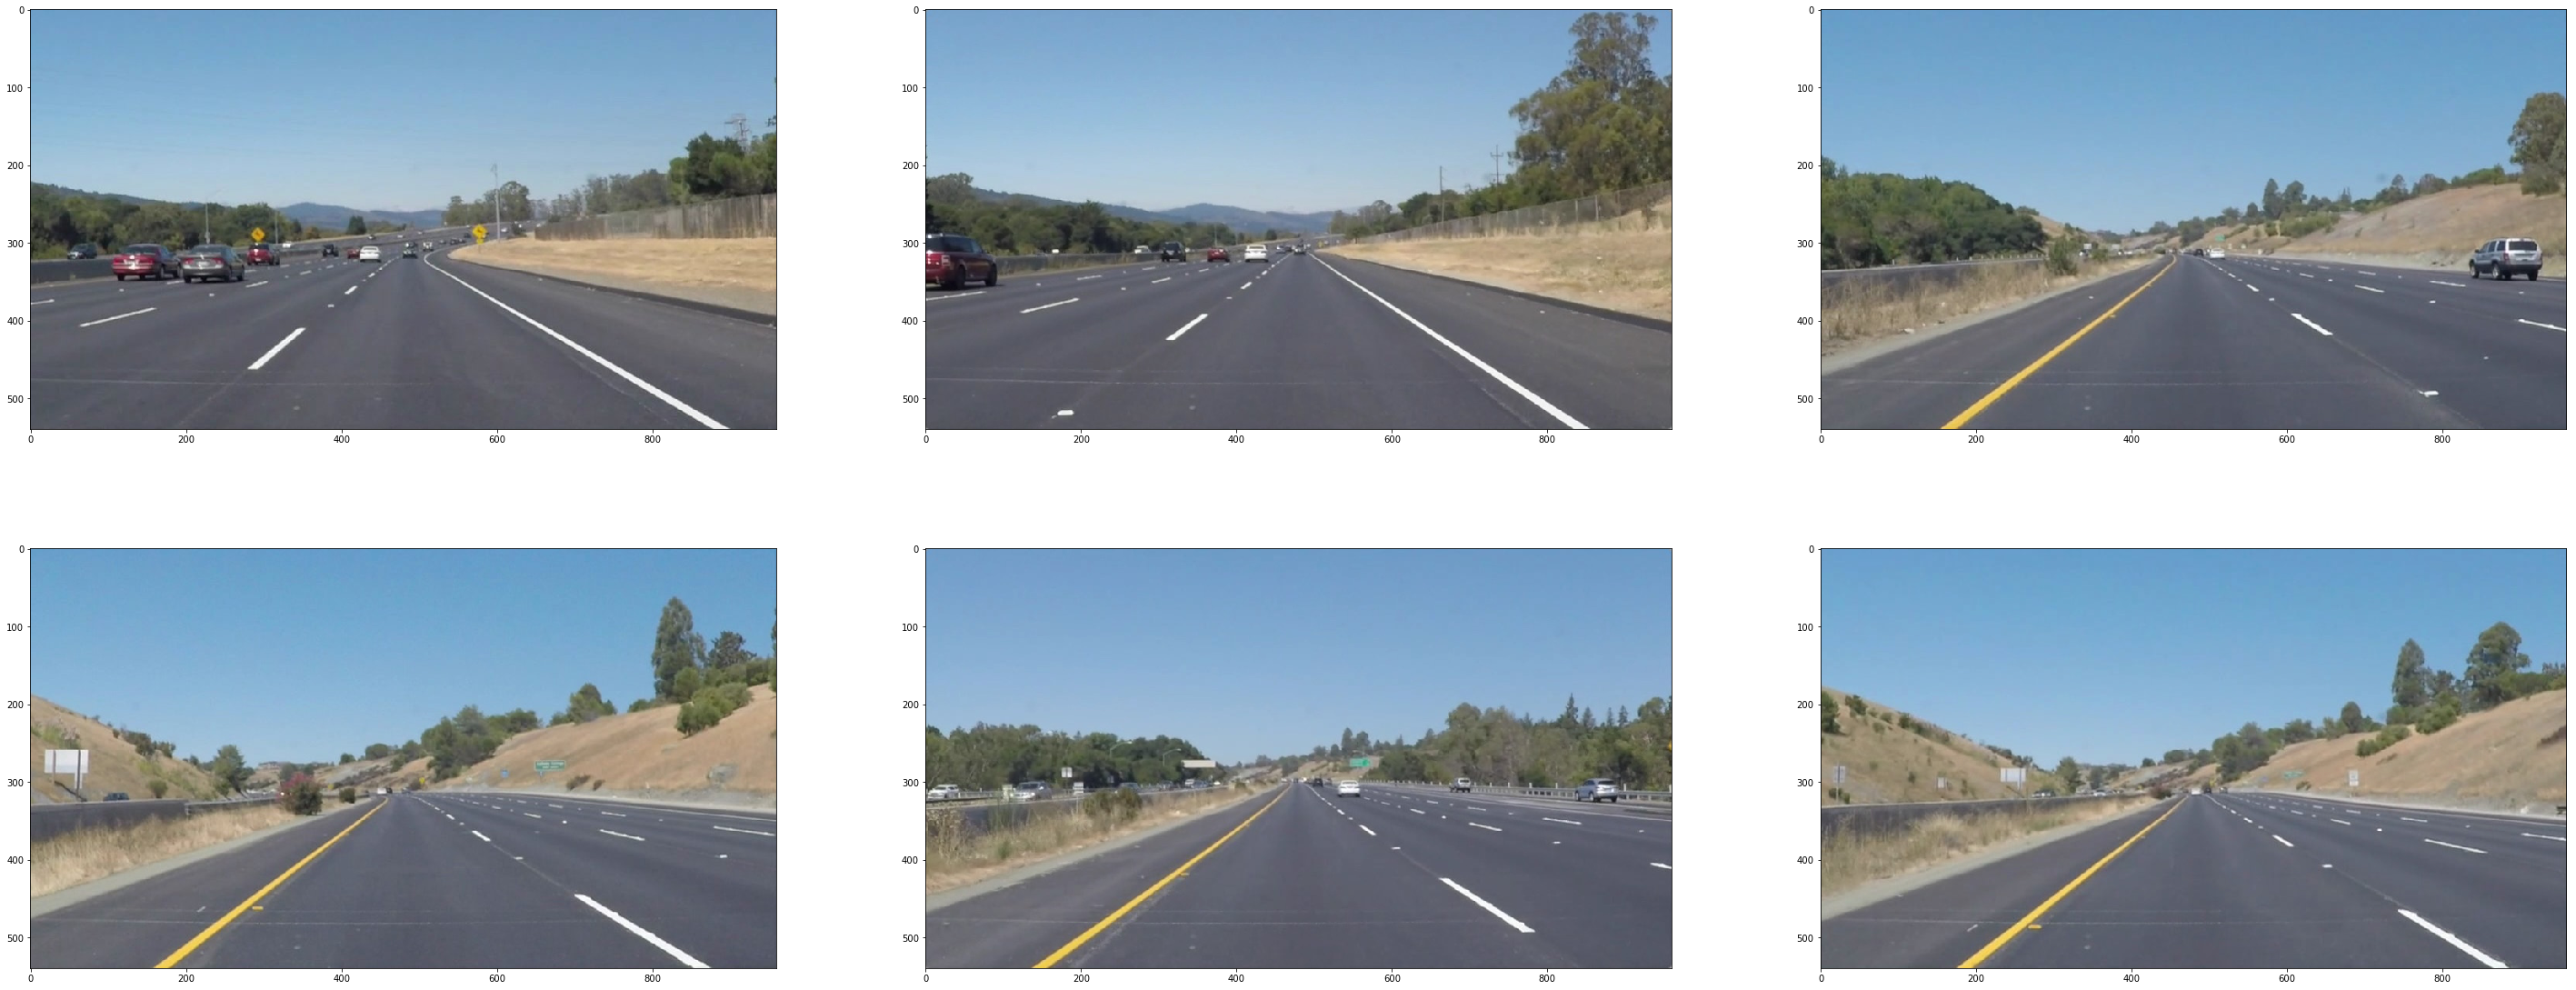

In [14]:
testDir = "test_images/"
testImageNames = showImages(testDir)
testImages = list(map(lambda img: plt.imread(testDir + img), testImageNames))

## 2. Convert images to grayscale

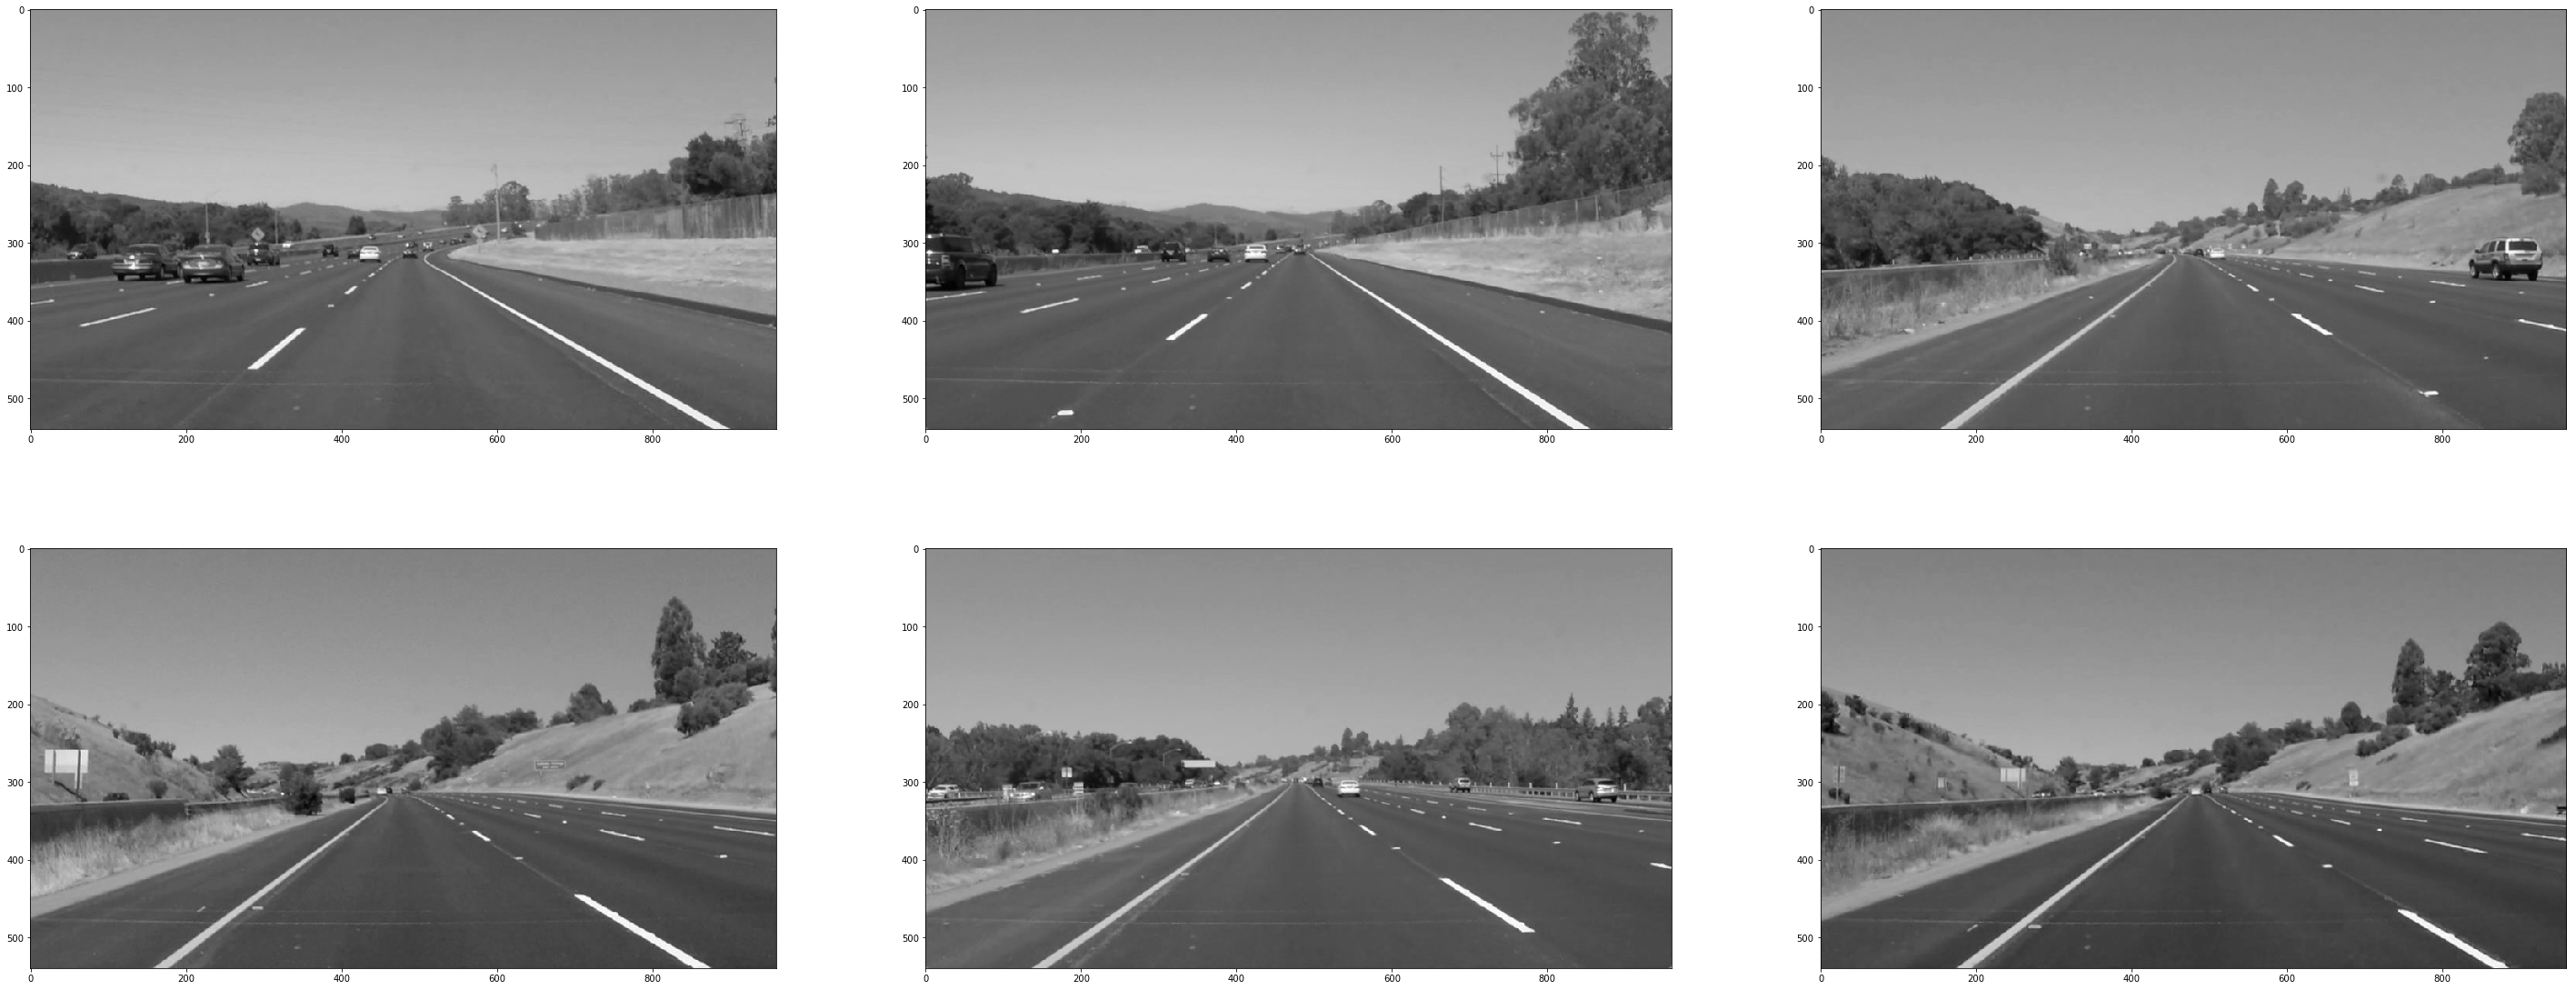

In [15]:
testGrayImages = SaveImages(testImages, "test_pipeline_results/test_images_gray/", testImageNames, grayscale, 1)

## 3. Gaussian Smoothing

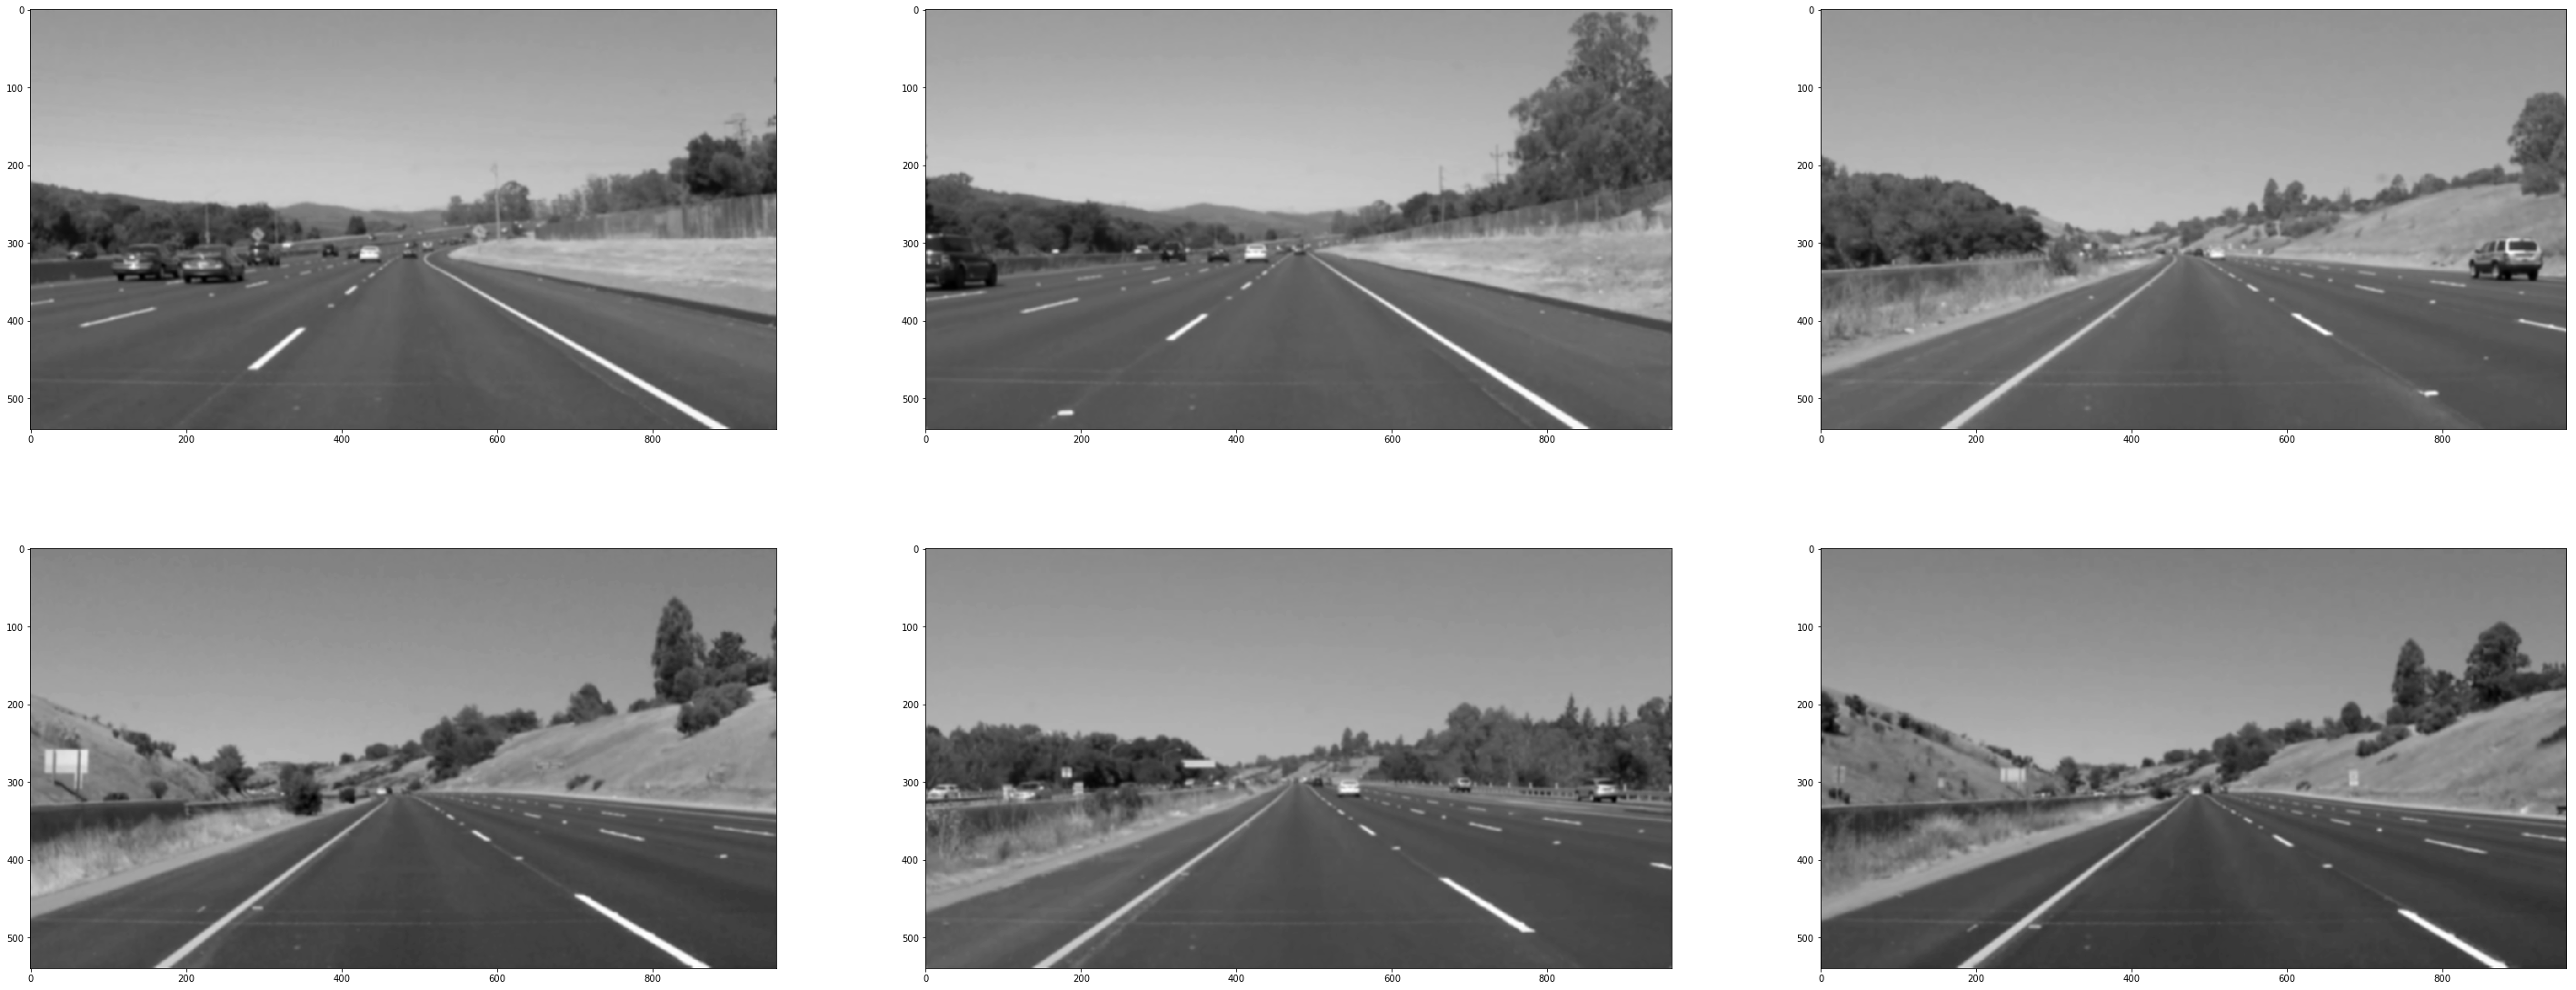

In [18]:
blurFunc = lambda img : gaussian_blur(img, kernel_size=7)

testBlurImages = SaveImages(testGrayImages, "test_pipeline_results/test_images_blur/", testImageNames, blurFunc, 1)

## 4. Apply Canny transform

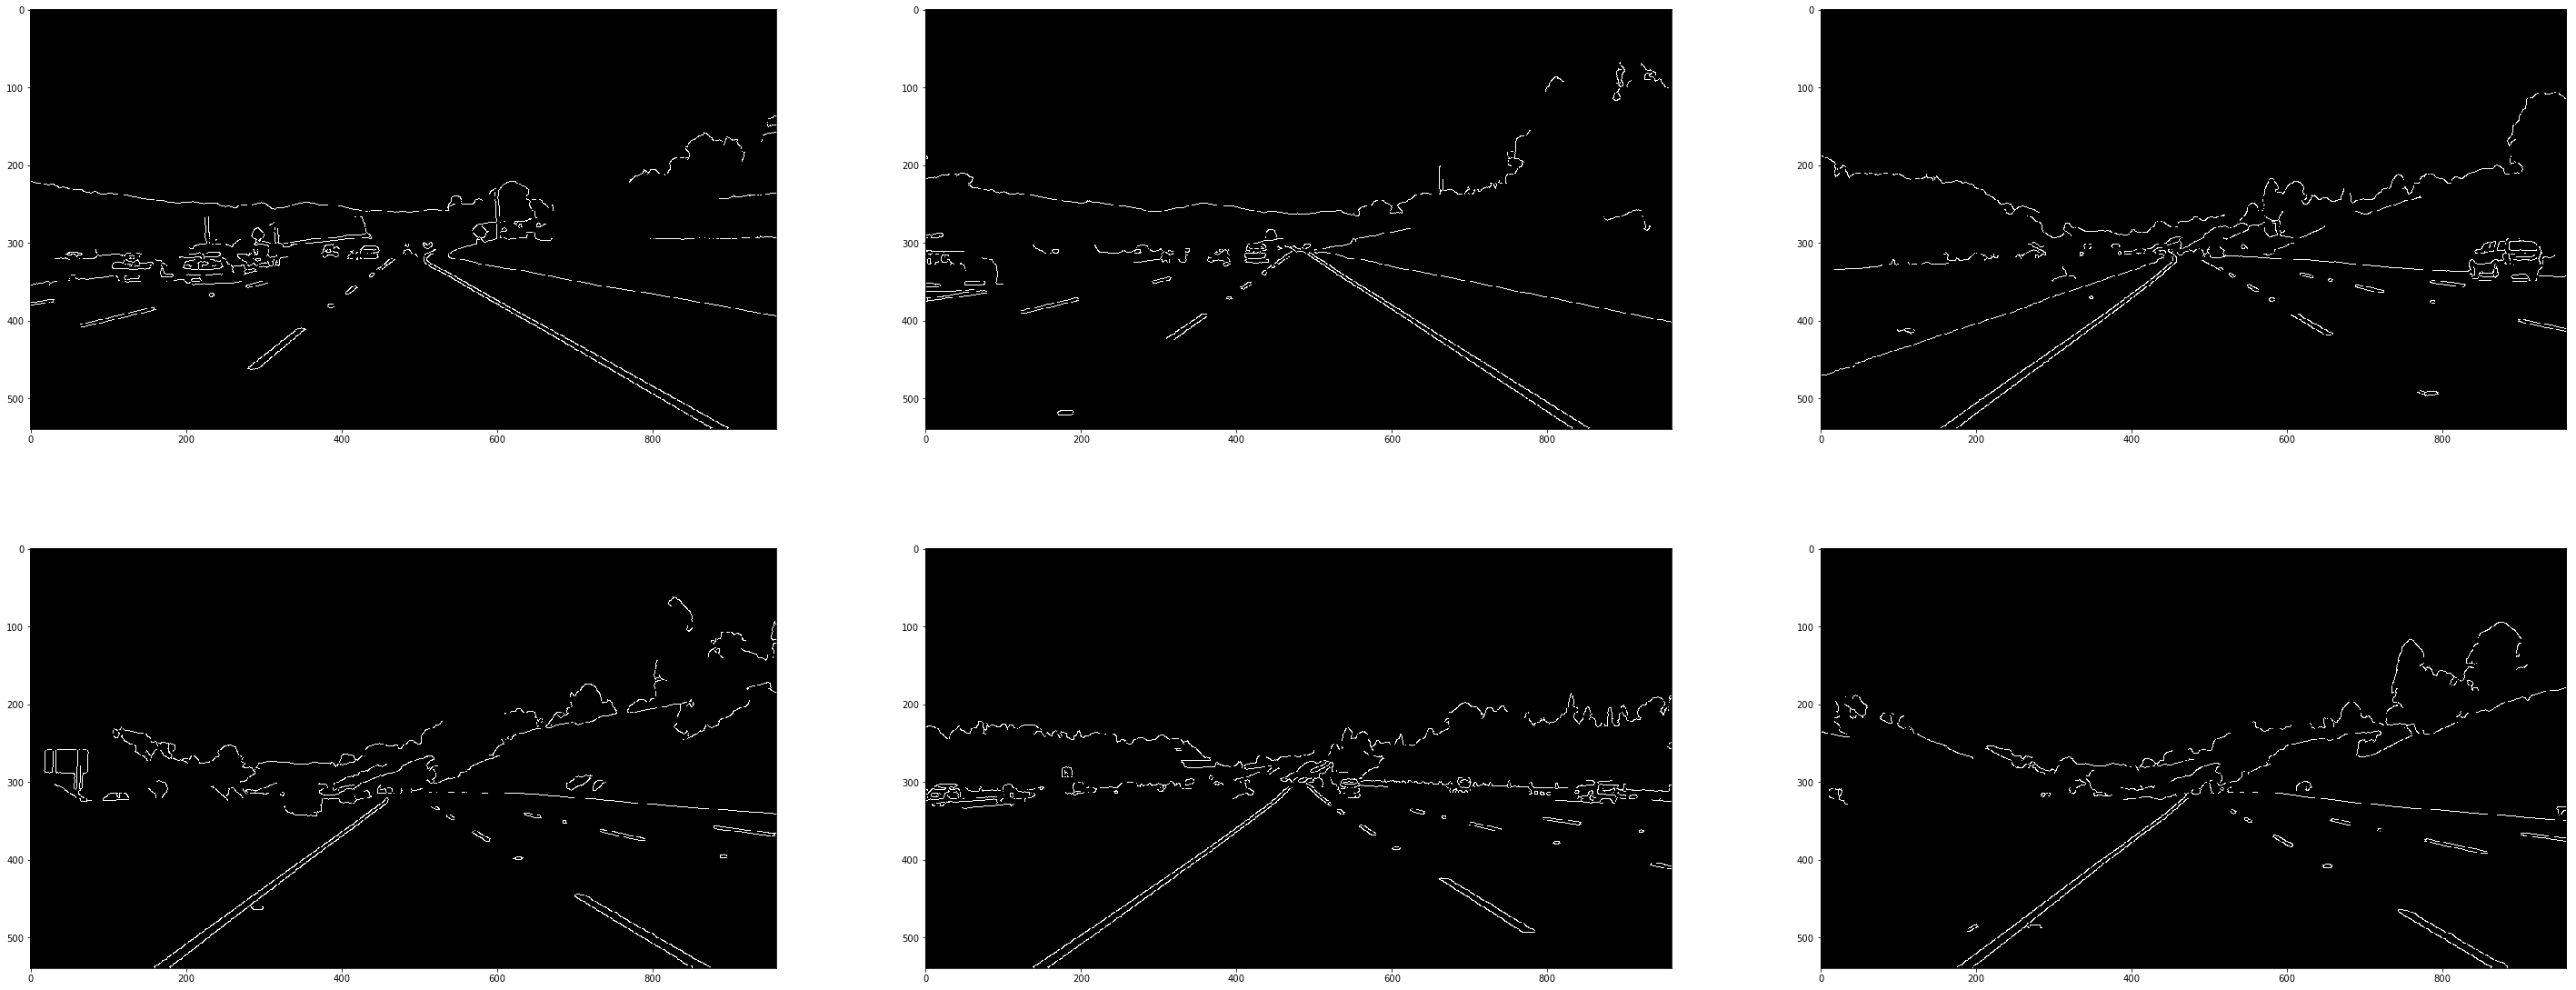

In [20]:
cannyFunc = lambda img: canny(img, low_threshold=50, high_threshold=150)

testCannyImages = SaveImages(testBlurImages, "test_pipeline_results/test_images_canny/", testImageNames, cannyFunc, 1)

## 5. Apply an image mask

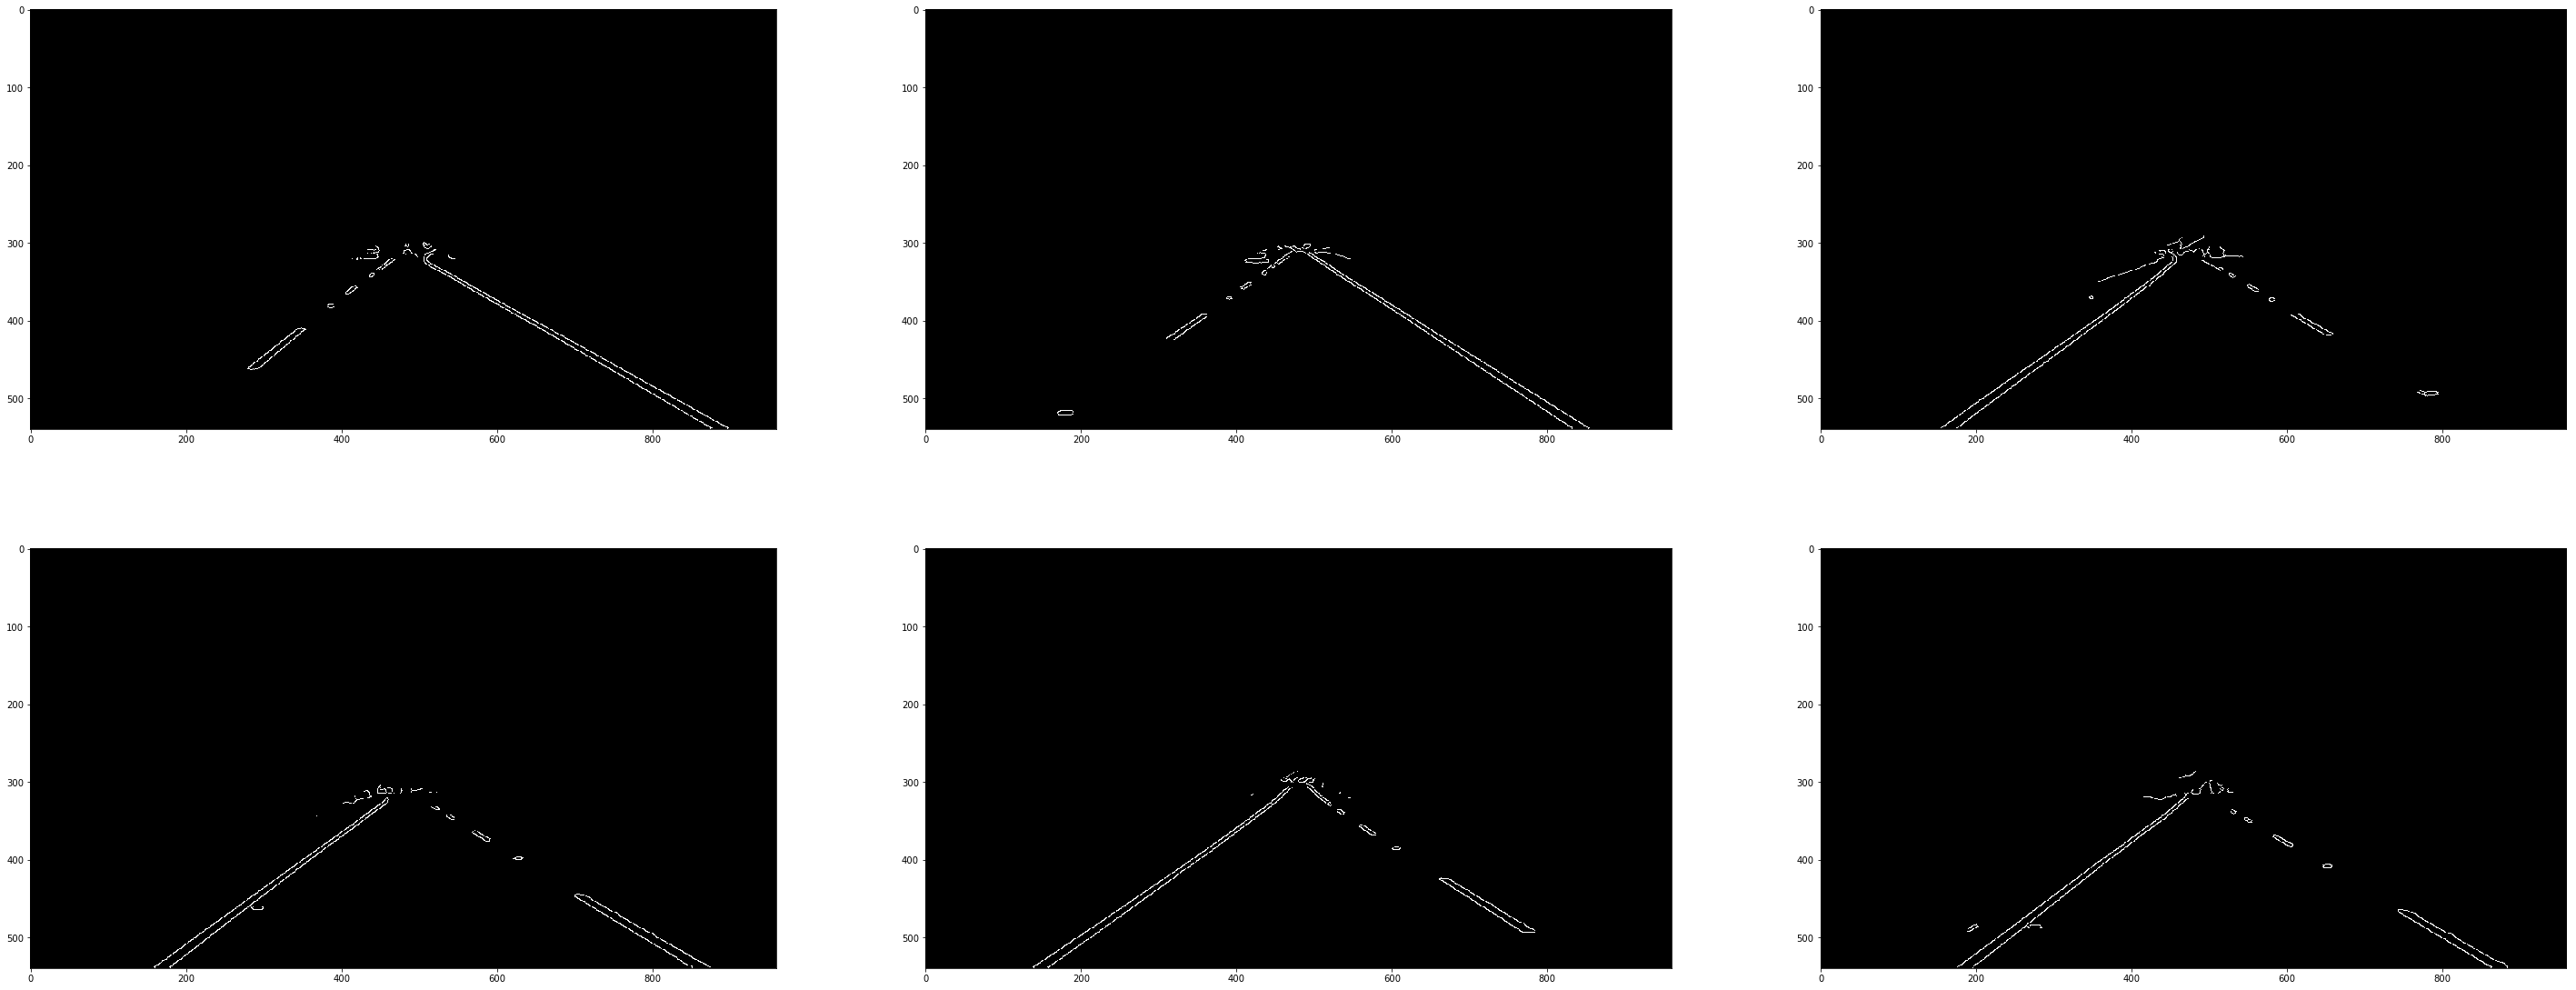

In [21]:
def maskFunc(img):
    xsize = img.shape[1]
    ysize = img.shape[0]
    regions = np.array([[(0, ysize), (xsize/2, ysize/2+15),(xsize, ysize)]], dtype=np.int32)
    return region_of_interest(img, regions)

testMaskedImage = SaveImages(testCannyImages, "test_pipeline_results/test_masked_image/", testImageNames, maskFunc, 1)

## 6. Apply Hough transformation

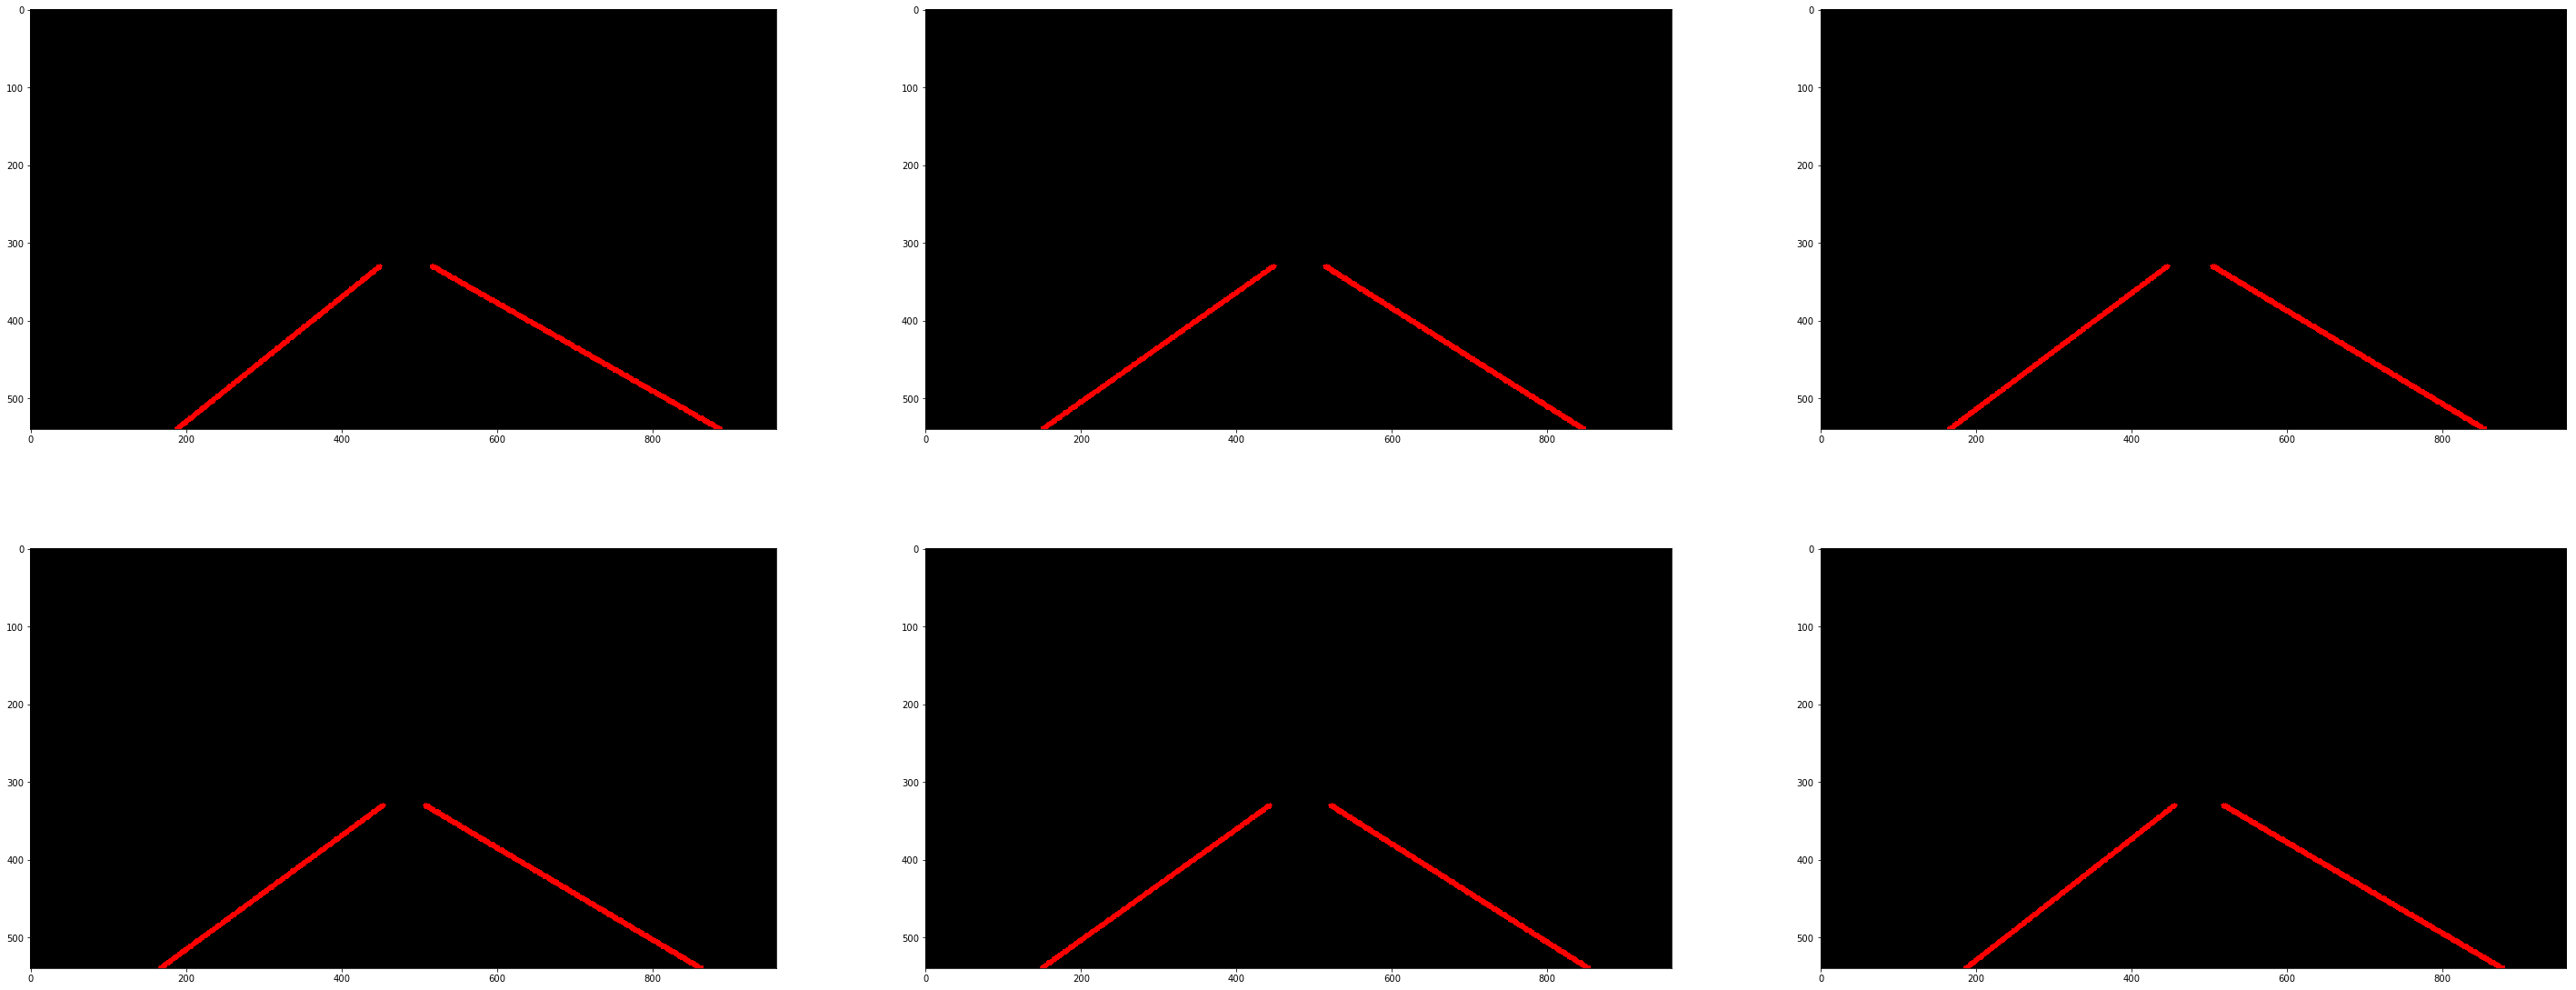

In [28]:
houghFunc = lambda img: hough_lines(img, rho=2, theta=np.pi/180, threshold=16, min_line_len=20, max_line_gap=3)
testImageLines = SaveImages(testMaskedImage, "test_pipeline_results/test_hough_image/", testImageNames, houghFunc)

## 7. Add lines to original images

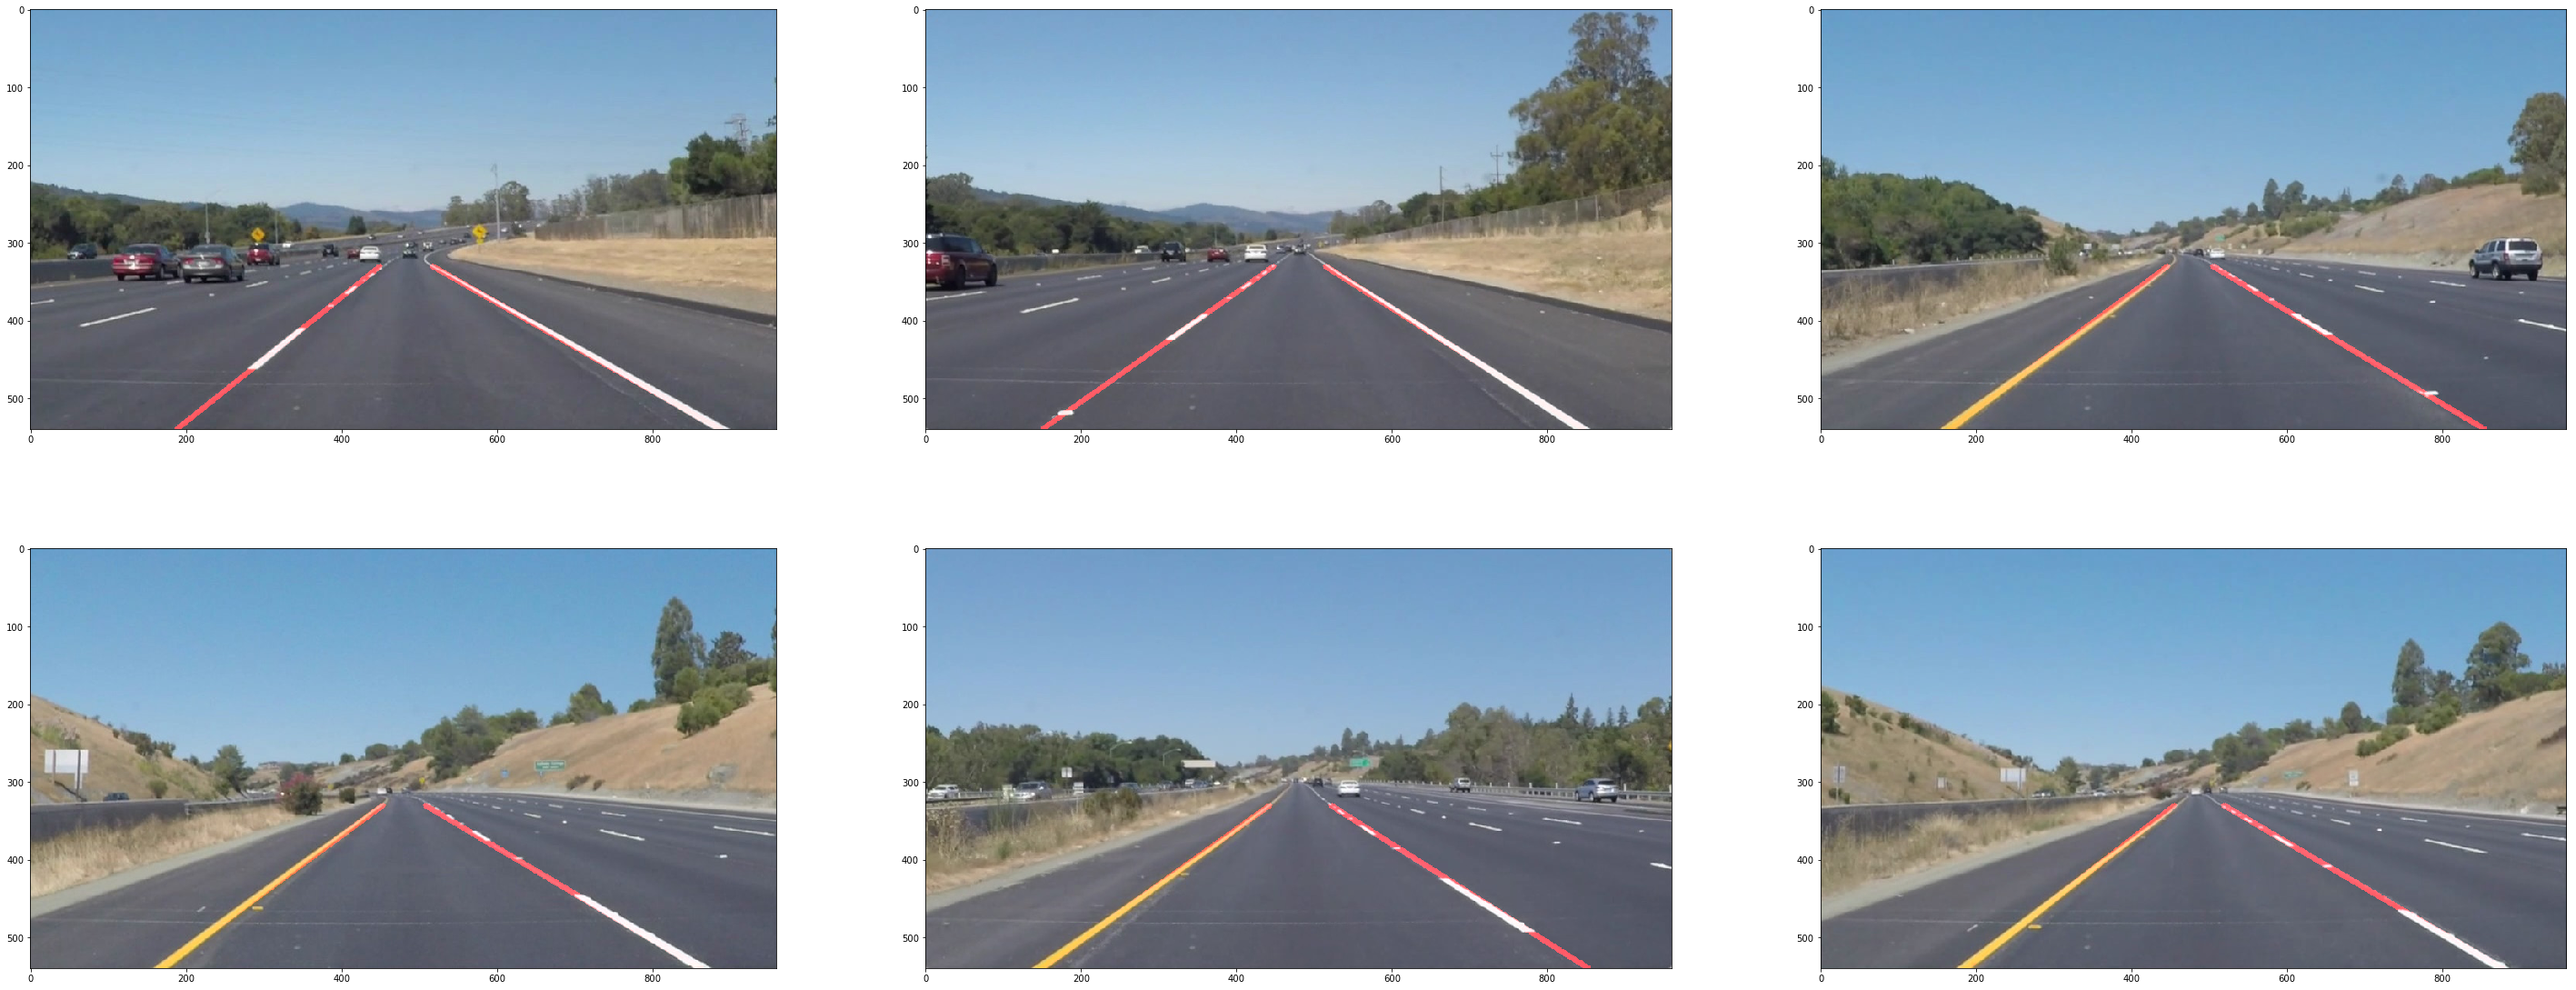

In [29]:
mergeFunc = lambda imgPair: weighted_img(imgPair[0], imgPair[1])
testMerged_Image = SaveImages(zip(testImages, testImageLines), 
                              "test_pipeline_results/test_merged_images/", 
                              testImageNames, mergeFunc)

In [36]:
def process_image(image):
    image = np.copy(image)
    gray = grayscale(image)
    blur = gaussian_blur(gray, kernel_size=5)
    canny_img = canny(blur, low_threshold=50, high_threshold=150)
    xsize = image.shape[1]
    ysize = image.shape[0]
    regions = np.array([[(0, ysize), (xsize/2, ysize/2+15),(xsize, ysize)]], dtype=np.int32)
    masked_img = region_of_interest(canny_img, regions)
    line_img = hough_lines(masked_img, rho=2, theta=np.pi/180, threshold=16, 
                           min_line_len=20, max_line_gap=3)
    result = weighted_img(image, line_img)
    return result

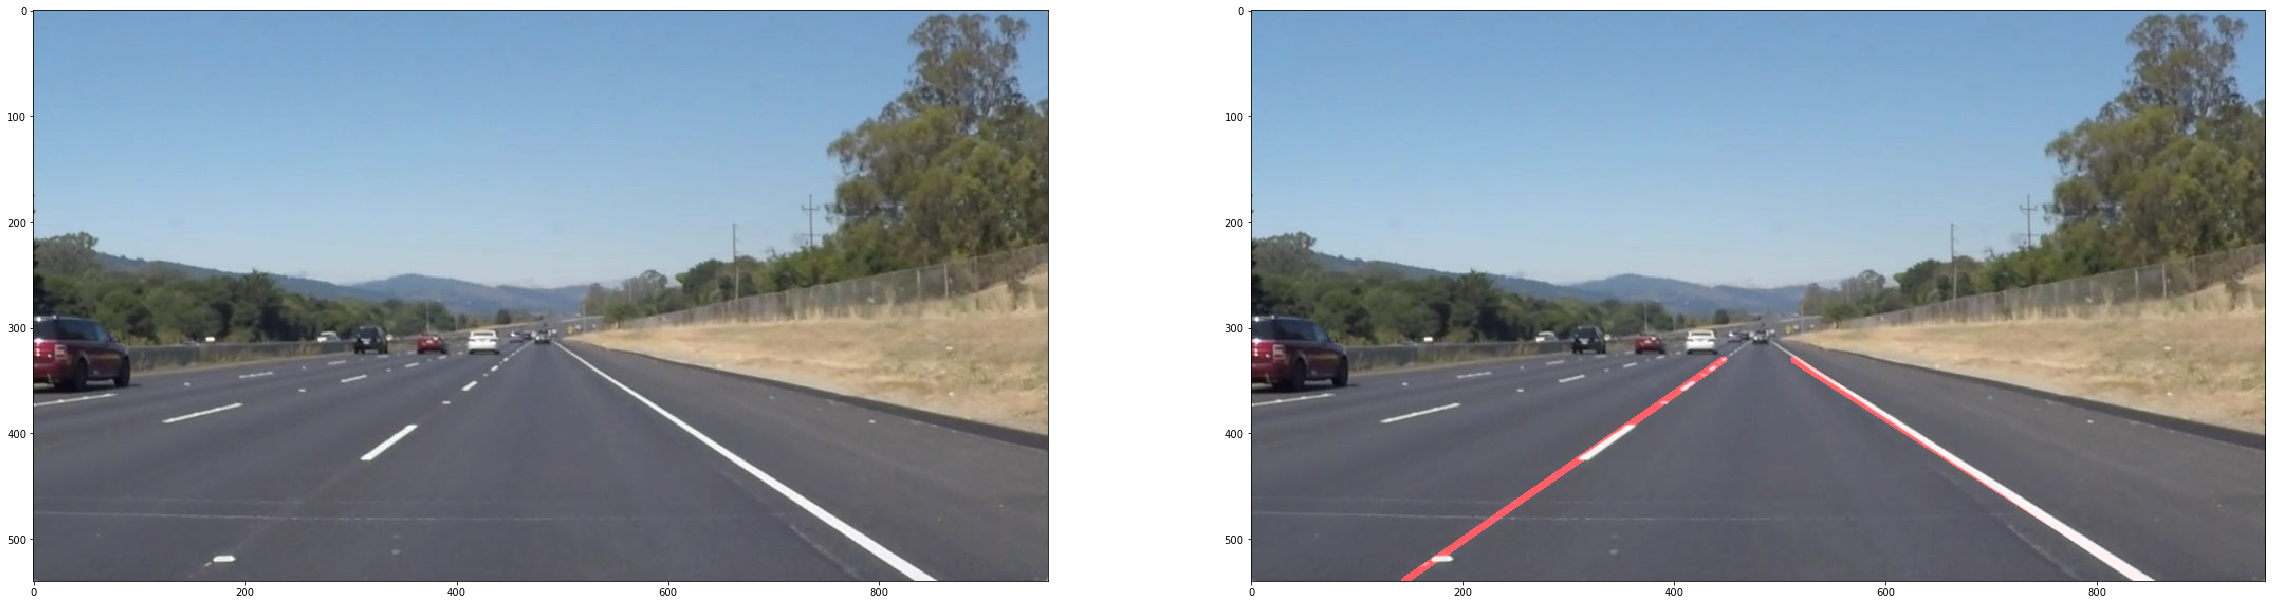

In [38]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.figure(figsize=(40, 20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(process_image(image))

## Test on Videos

In [44]:
def processVideo(videoName, inputVideoDir, outputVideoDir):
    if not os.path.exists(outputVideoDir):
        os.makedirs(outputVideoDir)
        
    clip = VideoFileClip(inputVideoDir + '/' + videoName)
    outputClip = clip.fl_image(process_image)
    outVideoFile = outputVideoDir + '/' + videoName
    outputClip.write_videofile(outVideoFile, audio=False)
    display(
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
        """.format(outVideoFile))
    )

In [48]:
# White lane video 
testVideoInputDir = "test_videos"
testVideoOutputDir = "test_videos_output"
processVideo("solidWhiteRight.mp4", testVideoInputDir, testVideoOutputDir)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4


In [49]:
# Yello lane video
processVideo('solidYellowLeft.mp4', testVideoInputDir, testVideoOutputDir)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4


## Challenge Video

In [50]:
# Challenge video 
processVideo('challenge.mp4', testVideoInputDir, testVideoOutputDir)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:  41%|███████████████████████████▊                                       | 104/251 [00:01<00:03, 48.07it/s, now=None]WARNING:py.warnings:C:\Users\shuai\miniconda3\envs\carlines\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

  ret, rcount, out=ret, casting='unsafe', subok=False)


t:  43%|█████████████████████████████                                      | 109/251 [00:02<00:03, 47.01it/s, now=None]WARNING:py.warnings:C:\Users\shuai\miniconda3\envs\carlines\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in int_scalars

t:  45%|██████████████████████████████▍                                    | 114/251 [00:02<00:02, 46.49it/s, now=None]WARNING:py.warnings:C:\Users\shuai\miniconda3\envs\carlines\lib\site-packages\ipykernel_launcher.py:72: RankWarning: Polyfit may be poorly conditioned

t:  48%|████████████████████████████████                                   | 120/251 [00:02<00:03, 42.

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4


When the video frame changes, the detected lane line will shake. The shadows on the road can affect the accuracy of the results.
Therefore, we should use a more robust algorithm to reduce the disturbance of the environment.